# Quantum-classical Mapping

## Code for simulating and infering the classical dynamics

We want to simulate the dynamics

$W\left(s^{\prime} \mid s\right)=W(s \mid s) \delta_{s^{\prime}, s}+\sum_{K=1,2,\dots k} \sum_{a_k} g_{a_k}(s) \delta_{s^{\prime}, F_{a_k}[s]}$

The dirac deltas are there only to tell you which of the states is actually selected, all the calculation is in the flip-probabilities $g_a = [{g_i, g_{ij}}]$. The indices refer to which spin will get flipped. Your data would have the form of $(s_0,s_1, \dots s_t)$ with $s_i$  being states of the system. The $a$ represents a n-spin flip.  $g_i$ is the probability of the flip occurring.

This expression tells us that the transition probability is the sum of all probabilities of all the ways to get into state $s'$ using up to $a$-spin flips. We can use it to calculate the transition rates from a time series. w is an extra parameter that encodes the time scales of the transitions. Not related to coupling between spins.

For fully connected systems we have the flipping parameters:

$g_i(s)=\exp \left[-w_{i i}-s_i\left(h_i+\sum_{i \neq j} J_{i j} s_j\right)\right]$

$g_{ij}(s) = \exp \left(-w_{ij}+J_{ij} s_is_j - s_i \left[\sum_{k} J_{ik} s_k + h_i \right] - s_j \left[ \sum_{k'} J_{jk'} s_{k'} + h_j \right] \right)$

Formalism -1/1 -> 1/0 for binary representation

We set $\beta = 1$ throughout the code

#### Do this first for 2 qubits, then upgrade
2- From time series, learn the weights in W [weights that generated transition matrix] and W directly

3- From W generate eta (ensuring DB; so symmetrize the thing)

5- inverse mapping from rho to W and interpret wyy, wxx terms.wxz [Combine QBM and dynamics simulation code]

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
from scipy.optimize import minimize
from numpy import linalg as LA
from numba import njit

In [25]:
###  SIMULATION FUNCTIONS
#----------------------------------------------------------------------
def g_single(i, s, w, h, J):
    """Probability associated with a single spin flip"""
    sum_term = h[i] + sum(J[i, j] * s[j] for j in range(len(s)) if i != j)
    return np.exp(-w[i, i] - s[i] * sum_term)

def g_double(i, j, s, w, h, J):
    """Probability associated with a double spin flip"""
    sum_term_i = h[i] + sum(J[i, k] * s[k] for k in range(len(s)) if k != i)
    sum_term_j = h[j] + sum(J[j, k] * s[k] for k in range(len(s)) if k != j)
    return np.exp(-w[i, j] + J[i, j] * s[i] * s[j] - s[i] * sum_term_i - s[j] * sum_term_j)

def flip_parallel(s, w, h, J, no_flip_prob):
    """Flipping algorithm using parallel dynamics using double-spin flips"""
    N = len(s)         # Number of spins in the lattice
    s_prime = s.copy()

    #calculate all possible flipping probabilities from state s
    flip_probs = [g_single(i, s, w, h, J) for i in range(N)]       # single flip probabilities
    # append double flip probabilities
    flip_probs += [g_double(i, j, s, w, h, J) for i in range(N) for j in range(i+1, N)]  #double flip probabilities
    
    # normalize the probabilities and append no flip probability
    flip_probs_sum = np.sum(flip_probs)
    flip_probs = [(1 - no_flip_prob) * prob / flip_probs_sum for prob in flip_probs]
    flip_probs.append(no_flip_prob)
    
    # randomly choose a spin flip according to its probability of occurring
    idx = np.random.choice(len(flip_probs), p=flip_probs)

    num_single_flips = N
    num_double_flips = math.comb(N, 2)  #binomial coefficient N choose 2

    # If the chosen index corresponds to a single or double flip, perform the flip
    if idx < num_single_flips:  # single flip
        s_prime[idx] *= -1
    elif idx < num_single_flips + num_double_flips:  # double flip
        idx -= num_single_flips
        i, j = divmod(idx, N-1) #calculate the indices i (quotient) and j (remainder) for the double flip
        if j >= i:              #correctly index the upper triangular part of the matrix
            j += 1
        s_prime[i] *= -1
        s_prime[j] *= -1
    # If the chosen index corresponds to no flip, do nothing
    else:  
        pass  # No flip

    return s_prime

def simulate_dynamics(w, J, h, steps, n_spins, no_flip_prob):
    s = np.array([np.random.choice(np.array([-1, 1])) for _ in range(n_spins)], dtype=np.int64) #initial config
    trajectory = np.empty((steps, n_spins), dtype=np.int64)
 
    for t in range(steps):
        s = flip_parallel(s,w,h,J, no_flip_prob)
        trajectory[t] = s 
        
    return trajectory

In [26]:
###  PLOTTING FUNCTIONS
#----------------------------------------------------------------------
def system_state(s):
    return ''.join(['0' if spin == 1 else '1' for spin in s])

def plot_combined_dynamics(trajectory, n_spins):
    fig, (ax1,ax2)= plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot for the system's evolution through states
    states = [''.join(str(1 - (spin + 1) // 2) for spin in traj) for traj in trajectory]  # convert spins to binary
    unique_states = sorted(set(states))
    state_indices = [unique_states.index(state) for state in states]
    
    ax1.plot(range(len(state_indices)), state_indices)
    ax1.set_yticks(range(len(unique_states)))
    ax1.set_yticklabels(unique_states)
    ax1.set_title("System's evolution through states")
    ax1.set_xlabel('Time step')
    ax1.set_ylabel('State')

    # Plot for the spins' evolution
    offset_labels = []
    y_ticks = []
    for i in range(n_spins):
        spin_trajectory = trajectory[:, i] + i * 3
        ax2.plot(range(len(spin_trajectory)), spin_trajectory, label=f'Spin {i+1}')
        offset_labels += ['0', '1']
        y_ticks += [(i*3 - 1), (i*3 +1)]
        
    ax2.set_title("Spins' evolution")
    ax2.set_xlabel('Time step')
    ax2.set_ylabel('Spin value (with offset)')
    ax2.set_yticks(y_ticks)
    ax2.set_yticklabels(offset_labels)
    ax2.legend(loc='best')
    ax2.plot()
    
    plt.tight_layout()
    plt.show()

def energy(s, J, h):
    """
    Compute the energy of the system in a particular spin state.
    """
    s = s.astype(np.float64)                              # convert the spin configuratio to float64 for numba
    pairwise_energy = np.dot(s, np.dot(J, s))
    local_field_energy = h * s                            # simple multiplication for scalar-array operation
    return -pairwise_energy - np.sum(local_field_energy)  # sum over local field energy

def boltzmann_distribution(J, h):
    n_spins = len(h)
    all_states = np.array([[1 if digit=='0' else -1 for digit in f"{i:0{n_spins}b}"] for i in range(2**n_spins)])
    energies = np.array([energy(state, J, h) for state in all_states])
    probabilities = np.exp(-energies)
    Z = np.sum(probabilities)
    return probabilities / Z

def plot_convergence_to_boltzmann(J, h, trajectory):
    n_spins = len(h)
    boltzmann_probs = boltzmann_distribution(J, h).flatten()

    # count the occurrences of each unique spin state in the trajectory
    state_counts = {}
    for state in trajectory:
        state_tuple = tuple(state)
        if state_tuple in state_counts:
            state_counts[state_tuple] += 1
        else:
            state_counts[state_tuple] = 1

    # calculate the empirical probabilities from the trajectory
    empirical_probs = np.zeros(2**n_spins)
    for idx, state in enumerate(np.array([[1 if digit=='0' else -1 for digit in f"{i:0{n_spins}b}"] for i in range(2**n_spins)])):
        state_tuple = tuple(state)
        if state_tuple in state_counts:
            empirical_probs[idx] = state_counts[state_tuple] / len(trajectory)


    # plot the Boltzmann probabilities and the empirical probabilities
    state_labels = [system_state(state) for state in np.array([[1 if digit=='0' else -1 for digit in f"{i:0{n_spins}b}"] for i in range(2**n_spins)])]
    x = np.arange(len(state_labels))
    width = 0.35

    fig, ax = plt.subplots(figsize=(6, 3))
    rects1 = ax.bar(x - width / 2, boltzmann_probs, width, label='Boltzmann', color='SteelBlue', alpha=0.8)
    rects2 = ax.bar(x + width / 2, empirical_probs, width, label='Empirical', color='Coral', alpha=0.8)

    ax.set_ylabel('Probability')
    ax.set_xlabel('Spin states')
    ax.set_title('Boltzmann vs Empirical Probabilities')
    ax.set_xticks(x)
    ax.set_xticklabels(state_labels)
    ax.legend()

    plt.show()

## Example simulation plot

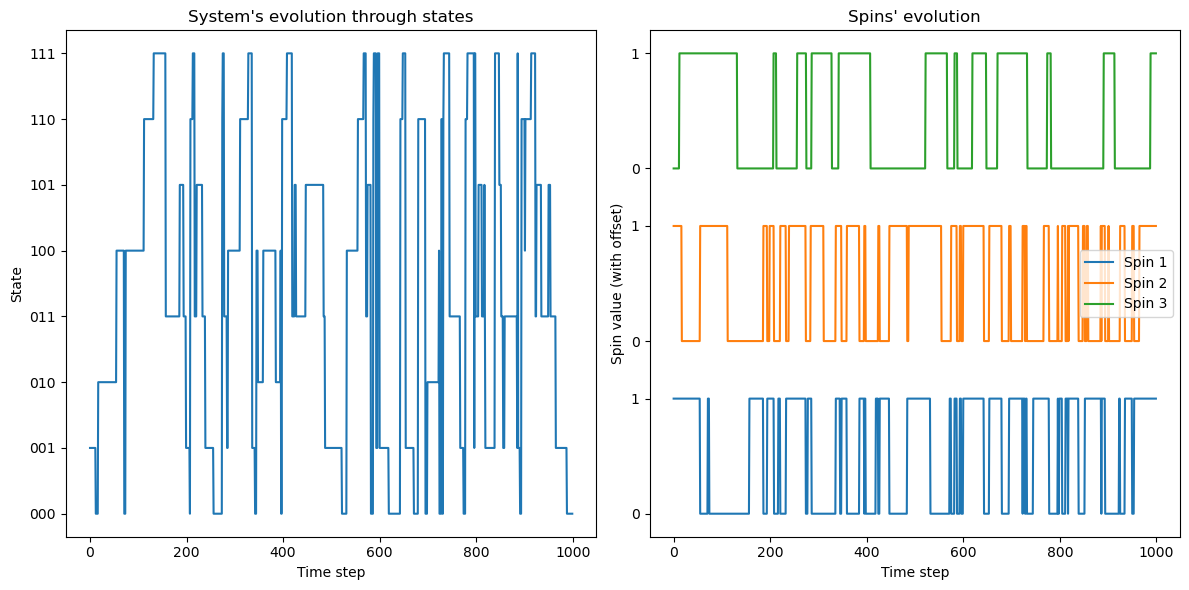

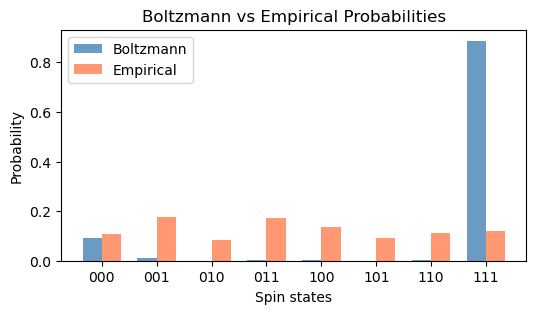

In [27]:
# Initialize parameters
n_spins = 3
steps = 1000
no_flip_prob = 0.9

w = np.random.normal(size=(n_spins, n_spins))
h = np.random.normal(size=n_spins)
J = np.random.normal(size=(n_spins, n_spins))

trajectory = simulate_dynamics(w, J, h, steps, n_spins,no_flip_prob)
plot_combined_dynamics(trajectory, n_spins)
plot_convergence_to_boltzmann(J, h, trajectory)


In [28]:
###TRANSITION MATRIX FUNCTIONS
#----------------------------
#THIS FUNCTION BASICALLY DOES THE SAME AS FLIP_PARALLEL. IF YOU WANT A MORE EFFICIENT ALGORITHM YOU SHOULD COMBINE THEM BUT FOR NOW ITS FINE
def transition_probabilities(s, w, h, J):
    """Calculates the row in the transition matrix corresponding to spin s"""
    N = len(s)
    transition_probs = np.zeros(2**N)
    
    for state_idx in range(2**N):
        s_prime = [(state_idx >> i) & 1 for i in reversed(range(N))] # binary representation with reversed order
        s_prime = (1 - np.array(s_prime)) * 2 - 1 # conversion to spin representation
        
        flipped_spins = np.where(s != s_prime)[0] # returns array with the indices of the differing spins 
        
        #calculate and store the transition probability associated with s'
        if len(flipped_spins) == 0:   #no spin flips
            transition_probs[state_idx] = 1.0
        elif len(flipped_spins) == 1: # single spin flip
            i = flipped_spins[0]
            transition_probs[state_idx] = g_single(i, s, w, h, J)
        elif len(flipped_spins) == 2: # double spin flip
            i, j = flipped_spins
            transition_probs[state_idx] = g_double(i, j, s, w, h, J)
        else:
            transition_probs[state_idx] = 0.0
            
    transition_probs /= np.sum(transition_probs)
    
    return transition_probs

#THIS BASICALLY DEFINES YOUR ENTIRE DYNAMICS; LARGE OBJECT TO COMPUTE
def model_transition_matrix(w, h, J):
    """Calculates the entire transition matrix"""
    N = len(w)
    states = [np.array([(i >> j) & 1 for j in reversed(range(N))]) for i in range(2**N)] # binary representation with reversed order
    states = [(1 - state) * 2 - 1 for state in states] # conversion to spin representation
    
    transition_matrix = np.zeros((2**N, 2**N))
    
    for i, s in enumerate(states):
        probs = transition_probabilities(s, w, h, J)
        transition_matrix[i, :] = probs
    
    return transition_matrix

def empirical_transition_matrix(data):
    n_spins = data.shape[1]
    all_states = np.array(list(itertools.product([-1, 1], repeat=n_spins)))

    # convert states of the data to indices
    state_indices = np.array([np.where((all_states == state).all(axis=1))[0][0] for state in data])

    # initialize transition matrix
    transition_matrix = np.zeros((2**n_spins, 2**n_spins))

    # count the transitions
    for i in range(len(state_indices) - 1):
        transition_matrix[state_indices[i], state_indices[i + 1]] += 1

    # normalize the transition matrix
    transition_matrix = transition_matrix / np.sum(transition_matrix, axis=1, keepdims=True)

    return transition_matrix

In [29]:
###  INFERENCE FUNCTIONS
#----------------------------------------------------------------------
def log_likelihood(params, data, n_spins):
    """Calculates the log-likelihood of the data given the parameters using the transition probabilities"""
    w = params[:n_spins**2].reshape(n_spins, n_spins)
    h = params[n_spins**2:n_spins**2+n_spins]
    J = params[n_spins**2+n_spins:].reshape(n_spins, n_spins)

    log_likelihood = 0
    for i in range(len(data) - 1):
        transition_prob = transition_probabilities(data[i],w, h, J)[data[i+1]]
        log_likelihood += np.log(transition_prob)
    
    return -log_likelihood  # we return the negative likelihood because we want to minimize this function


def infer_transition_matrix():
    """ From the inferred parameters, calculate the associated transition matrix"""
    return 

def W_to_rho(W):
    """Compute the symmetrized density matrix associated with the eigenvalue 1 of the transition matrix W"""

    ## MAYBE SYMMETRIZE W FIRST AND THEN USE linalg.eigh() INSTEAD? EMPIRICAL W WILL ALWAYS BE NON-SYMMETRIC.
    eig_vals, eig_vecs = np.linalg.eig(W)
    
    # find the eigenvector corresponding to the eigenvalue 1
    idx = np.argmin(np.abs(eig_vals - 1.0))
    eig_vec_1 = eig_vecs[:, idx]

    # construct the density matrix rho = |v><v|
    rho = np.outer(eig_vec_1, eig_vec_1.conj())

    # symmetrize the density matrix
    rho = (rho + rho.T.conj()) / 2
    
    return rho

def rho_to_W(rho):
    """ Compute the transition matrix associated with the density matrix rho. """
    N = len(rho)
    W = np.zeros((N, N), dtype=np.complex128)

    for i in range(N):
        for j in range(N):
            W += rho[i, j] * np.outer(np.eye(N)[i], np.eye(N)[j])

    return W


## Results N = 1

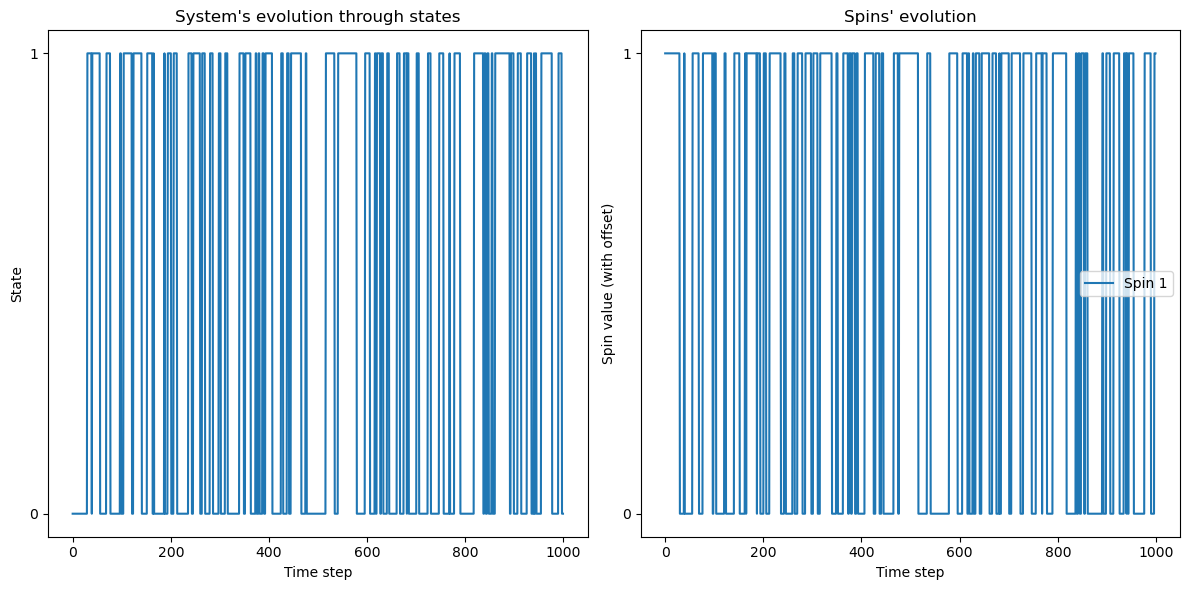

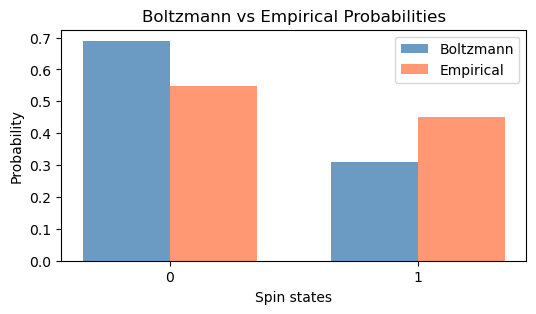

Emperical W: 
 [[0.88053097 0.11946903]
 [0.09872029 0.90127971]]
Model W: 
 [[0.80218389 0.19781611]
 [0.35434369 0.64565631]]
Inferred w: [[0.07992944]], Inferred h: [-19.36691789], Inferred J: [[-0.79916452]]


In [32]:
n_spins = 1
w = np.array([[1]])
J = np.array([[1]])
h = np.array([0.4])

steps = 1000
no_flip_prob = 0.9

#SIMULATE SYSTEM [FORWARD PROBLEM]
trajectory = simulate_dynamics(w, J, h, steps, n_spins, no_flip_prob)
plot_combined_dynamics(trajectory, n_spins)
plot_convergence_to_boltzmann(J, h, trajectory)

#INFERENCE [INVERSE PROBLEM]
W_empirical = infer_empirical_transition_matrix(trajectory)
print(f"Emperical W: \n {W_empirical}")
W_model = model_transition_matrix(w, h, J)
print(f"Model W: \n {W_model}")



## Results N = 2

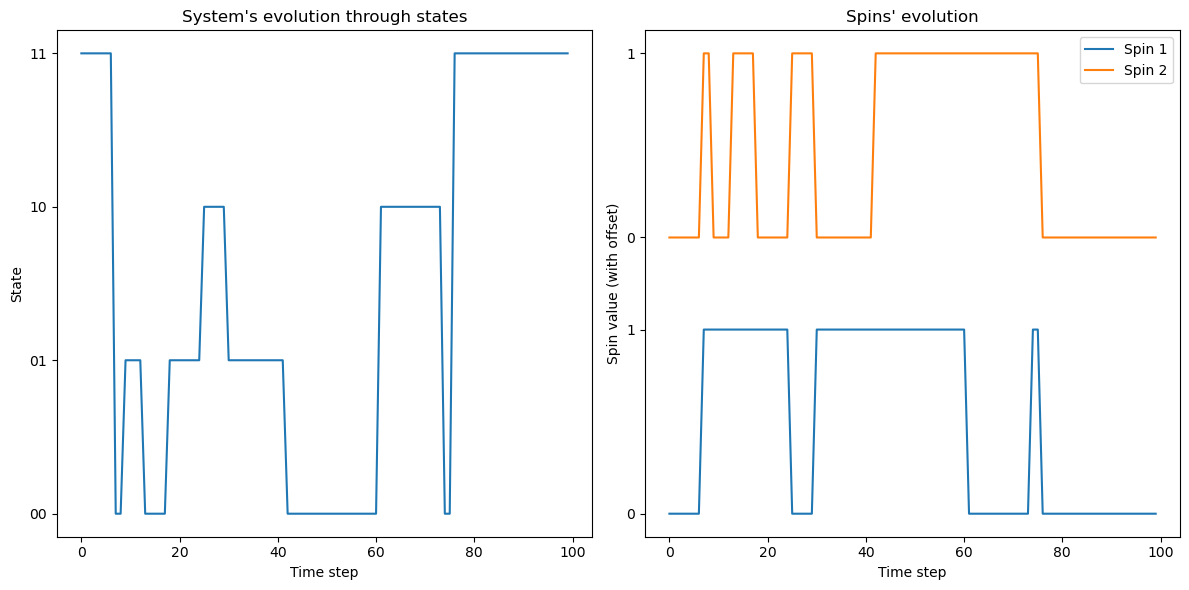

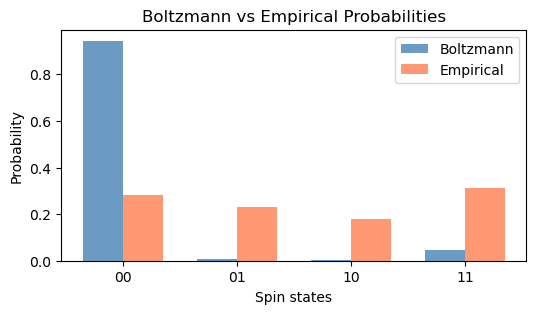

Emperical W: 
 [[0.96666667 0.         0.         0.03333333]
 [0.         0.88888889 0.05555556 0.05555556]
 [0.         0.04347826 0.86956522 0.08695652]
 [0.03571429 0.03571429 0.07142857 0.85714286]]
Model W: 
 [[0.88083109 0.05919671 0.03590462 0.02406758]
 [0.42184872 0.31251322 0.17151089 0.09412717]
 [0.42684347 0.28612174 0.19179314 0.09524165]
 [0.26999287 0.14817523 0.08987282 0.49195908]]


ValueError: The user-provided objective function must return a scalar value.

In [35]:
n_spins = 2
w = np.array([[1.2,1.1],
              [1.1,1.2]])
J = np.array([[1.,1.],
              [1.,1.]])
h = np.array([1.0, 0.5])

steps = 100
no_flip_prob = 0.9

#SIMULATE SYSTEM [FORWARD PROBLEM]
trajectory = simulate_dynamics(w, J, h, steps, n_spins, no_flip_prob)
plot_combined_dynamics(trajectory, n_spins)
plot_convergence_to_boltzmann(J, h, trajectory)

#INFERENCE [INVERSE PROBLEM]
W_empirical = infer_empirical_transition_matrix(trajectory)
print(f"Emperical W: \n {W_empirical}")
W_model = model_transition_matrix(w, h, J)
print(f"Model W: \n {W_model}")

inferred_w, inferred_h, inferred_J = infer_parameters_scipy(trajectory, n_spins)
print(f"Inferred w: {inferred_w}, Inferred h: {inferred_h}, Inferred J: {inferred_J}")


## Code for the 2-qubit QBM

In [ ]:
@njit
def expmat(A):
    """
    Computes the exponential of a given matrix `A'.
    """
    A = 0.5 * (A + np.transpose(np.conjugate(A)))
    evals, evecs = np.linalg.eigh(A)
    N = len(evals)
    res = np.zeros((N,N),np.complex64)
    for i in range(N):
        eigenvector = evecs[:,i]
        projector = np.outer(eigenvector,eigenvector.conj())
        res += np.exp(evals[i]) * projector
    return res

@njit
def logmat(A):
    """
    Computes the natural logarithm of a given matrix `A`.
    """
    A = 0.5 * (A + np.transpose(np.conjugate(A)))
    evals, evecs = np.linalg.eigh(A)
    N = len(evals)
    res = np.zeros((N,N),np.complex64)
    for i in range(N):
        eigenvector = evecs[:,i]
        projector = np.outer(eigenvector,eigenvector)
        res += np.log(evals[i]) * projector
    return res

def generate_interaction_matrices():
    """
    Constructs the tensor product of Pauli matrices for each spin and 
    uses them to build the interaction matrices between the two spins.
    """
    pauI = np.array([[1,0],[0,1]],np.complex64)
    pauX = np.array([[0,1],[1,0]],np.complex64)
    pauY = np.array([[0,-1j],[1j,0]],np.complex64)
    pauZ = np.array([[1,0],[0,-1]],np.complex64)
    pau = np.array([pauI, pauX, pauY, pauZ], dtype=np.complex64)

    interactions = np.zeros((4, 4, 4, 4), dtype=np.complex64)
    for k in range(4):
        for kprime in range(4):
            interactions[k, kprime] = np.kron(pau[k], pau[kprime])
    return interactions


@njit
def hamiltonian2spins(J,interactions):
    """
    Calculates the Hamiltonian matrix of a two-spin system 
    """
    H = np.zeros((4,4),np.complex64)
    for k in range(4):
        for kprime in range(4):
            H += J[k,kprime] * interactions[k,kprime]
    return H

@njit
def rho_model(J,interactions):
    """
    Computes the density matrix of a two-spin system using the Hamiltonian
    and the interaction matrices, and then normalizes it. Exact Diagonalization.
    """
    H      = hamiltonian2spins(J,interactions)        #  get hamiltonian matrix
    rho    = expmat(H)                                #  defintion of rho
    Z      = np.real(np.trace(rho))                   #  get Z
    rho   /= Z                                        #  normalize such that Tr[rho] = 1
    return rho

@njit
def observables(rho, interactions):
    """
    Computes the expectation values of the interaction matrices [observables]
    """
    obs = np.zeros((4,4))
    for k in range(4):
        for kprime in range(4):
            obs[k,kprime] = np.real(np.trace(rho@interactions[k,kprime]))
    return obs

@njit
def KL_divergence(eta,rho):
    """
    Calculates the KL divergence between the model and target distribution.
    """
    return np.real(np.trace(eta@(logmat(eta)-logmat(rho))))

@njit
def generate_obs(J, interactions):
    rho  = rho_model(J, interactions)         # compute density matrix using ED
    obs  = observables(rho, interactions)     # get QM statistics  
    return rho, obs

@njit
def generate_interaction_matrix(seed):
    np.random.seed(seed)              # set random seed for reproducibility
    J = np.random.randn(4, 4)         # get normal distributed weights
    J[0, 0] = 0
    return J

@njit
def learn_w(interactions, lr, maxiter, tol, rho_seed, eta_seed):
    """
    Train the model to fit the target distribution eta
    """
    
    J_eta            = generate_interaction_matrix(eta_seed)       #  get clamped QM statistics
    eta, obs_clamped = generate_obs(J_eta, interactions)
    
    J                = generate_interaction_matrix(rho_seed)       #  get free QM statistics 
    rho, obs_model   = generate_obs(J, interactions)     
    
    it = 0                                                 #  initialize gradient ascent loop
    diff = np.max(np.abs(obs_model-obs_clamped))
    Wmax_list = np.zeros(maxiter)                          #  initialize values to store
    KL_list   = np.zeros(maxiter)
    
    
    while (diff > tol and it < maxiter): 
        rho, obs_model  = generate_obs(J, interactions)    #  get free QM statistics
        J              += lr * (obs_clamped -  obs_model)  #  update weights
        
        diff = np.max(np.abs(obs_model-obs_clamped))       #  evaluate differences in clamped and model statistics        
        Wmax = np.max(np.abs(J-J_eta))
        
        Wmax_list[it] = Wmax                               #  store values
        KL_list[it]   = KL_divergence(eta,rho)
        it += 1 
    return J, J_eta, KL_list, Wmax_list, it

In [ ]:
#learning parameters
lr       = 1.2      #  learning rate 
maxiter  = 2**16    #  iterations
tol      = 1e-10    #  tolerance

interactions     = generate_interaction_matrices()     #  generate interaction matrices
J, J_eta, KL, Wmax, it = learn_w(interactions, lr, maxiter, tol, rho_seed, eta_seed)


In [ ]:
def generate_w(wx1x2, wy1y2, w1z2z, hx1, hx2, hy1, hy2, hz1, hz2):
    return np.array([
        [0,  hx2, hy2, hz2],
        [hx1, wx1x2, 0,  0],
        [hy1, 0,  wy1y2, 0],
        [hz1, 0,  0,  w1z2z]
    ])

#interaction parameters
wx1x2 = 0
wy1y2 = 0
wz1z2 = 2
hx1   = 0
hx2   = 0
hy1   = 0
hy2   = 0
hz1   = 1
hz2   = 1
    
w = generate_w(wx1x2 ,wy1y2, wz1z2, hx1, hx2, hy1, hy2, hz1, hz2)

## DANGER ZONE: 2+ QUBITS

In [ ]:
###Redundant functions

def flip_metropolis(s, J, h, beta, flip_two_spins=False):
    """Flipping algorithm using sequential dynamics and metropolis hashting"""
    s_prime = np.copy(s)
    
    #select spins to be flipped
    if flip_two_spins and np.random.rand() < 0.5:
        flip_indices = np.random.permutation(len(s))[:2]     # selects two spin indices to be flipped
    else:
        flip_indices = np.array([np.random.randint(len(s))]) # selects a single spin index to be flipped
    
    # flip the spins and calculate energy difference
    s_prime[flip_indices] *= -1
    delta_E = energy(s_prime, J, h) - energy(s, J, h)
    
    # accept or reject new state based on metropolis update rule
    if delta_E < 0 or np.random.rand() < np.exp(-beta * delta_E):
        s = s_prime
    
    return s

def infer_parameters_scipy(data, n_spins):
    """Infer the parameters using some Scipy minimzation of the likelihood. Implement QBM later"""
    w = np.random.normal(size=(n_spins, n_spins))
    h = np.random.normal(size=n_spins)
    J = np.random.normal(size=(n_spins, n_spins))

    initial_guess = np.concatenate((w.flatten(), h.flatten(), J.flatten()))
    result = minimize(log_likelihood, initial_guess, args=(data,n_spins), method='BFGS')

    if result.success:
        inferred_params = result.x
        inferred_w = inferred_params[:n_spins**2].reshape(n_spins, n_spins)
        inferred_h = inferred_params[n_spins**2:n_spins**2+n_spins]
        inferred_J = inferred_params[n_spins**2+n_spins:].reshape(n_spins, n_spins)
        return inferred_w, inferred_h, inferred_J
    else:
        raise ValueError(result.message)